# C++ Plagiarism Detection - Systematic Experimental Testing

## 🎯 Objective
Systematically evaluate plagiarism detection performance across different configurations:

- **Problem variations**: 2, 10, 20, 50 problems
- **Sample variations**: 100, 1,000, 5,000, 10,000 samples  
- **Total experiments**: 16 (4 × 4 combinations)
- **Evaluation metric**: F1-Score on test set

## 📋 Methodology
1. Load POJ-104 C++ dataset
2. For each configuration:
   - Create balanced dataset (50% clone, 50% non-clone)
   - Train CodeBERT model (2 epochs)
   - Optimize threshold on validation set
   - Evaluate F1-score on test set
3. Generate comprehensive summary table

## ✅ Professional Features
- Clean, modular code structure
- Proper train/validation/test splits
- Balanced dataset creation
- Reproducible experiments
- Comprehensive visualization

In [ ]:
# Import required libraries
import os
import re
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from itertools import combinations
from collections import Counter
from datetime import datetime
import time

# Machine Learning libraries
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    precision_recall_curve, classification_report, confusion_matrix
)

# Configuration
warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*70)
print("🚀 ENVIRONMENT SETUP COMPLETE")
print("="*70)
print(f"   Device: {device}")
print(f"   PyTorch version: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")
print("="*70)

🚀 ENVIRONMENT SETUP COMPLETE
   Device: cuda
   PyTorch version: 2.8.0+cu126
   CUDA available: True


## 1. Load Dataset

Loading POJ-104 C++ code clone detection dataset from Hugging Face.

In [ ]:
# Load POJ-104 dataset
print("📥 Loading POJ-104 Dataset...")
dataset = load_dataset("google/code_x_glue_cc_clone_detection_poj104")

print("\n📊 Dataset Information:")
print(f"   Train samples: {len(dataset['train']):,}")
print(f"   Validation samples: {len(dataset['validation']):,}")
print(f"   Test samples: {len(dataset['test']):,}")
print(f"   Columns: {dataset['train'].column_names}")

# Analyze sample
sample = dataset['train'][0]
print(f"\n🔍 Sample Structure:")
for key, value in sample.items():
    if isinstance(value, str):
        preview = value[:80] + "..." if len(value) > 80 else value
        print(f"   {key}: {preview}")
    else:
        print(f"   {key}: {value}")

print(f"\n✅ Dataset loaded successfully")

📥 Loading POJ-104 Dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/8.03M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/32500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12000 [00:00<?, ? examples/s]


📊 Dataset Information:
   Train samples: 32,500
   Validation samples: 8,500
   Test samples: 12,000
   Columns: ['id', 'code', 'label']

🔍 Sample Structure:
   id: 0
   code: int numcount=0;
void divide(int num,int x)
{
	int i;
	if(num==1)
		numcount...
   label: 1

✅ Dataset loaded successfully


## 2. Helper Functions

Core functions for dataset creation, model training, and evaluation.

In [ ]:
def normalize_code(code):
    """Normalize C++ code for consistent processing"""
    if not code or not isinstance(code, str):
        return ""

    # Remove inline comments
    code = re.sub(r'//.*$', '', code, flags=re.MULTILINE)
    # Remove multiline comments
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    # Normalize whitespace
    code = re.sub(r'\s+', ' ', code).strip()

    return code


def create_balanced_dataset(n_problems, n_samples, clone_ratio=0.5, seed=42):
    """
    Create balanced dataset for plagiarism detection

    Args:
        n_problems: Number of problems to use
        n_samples: Total number of code pairs
        clone_ratio: Ratio of clone pairs (default 0.5)
        seed: Random seed

    Returns:
        DataFrame with normalized code pairs and labels
    """
    random.seed(seed)
    np.random.seed(seed)

    # Get top N problems by sample count
    train_data = dataset['train']
    label_counts = Counter([int(train_data[i]['label'])
                           for i in range(min(10000, len(train_data)))])
    top_problems = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:n_problems]
    selected_problems = [label for label, _ in top_problems]

    # Collect samples by problem
    problem_samples = {pid: [] for pid in selected_problems}
    for i in range(len(train_data)):
        label = int(train_data[i]['label'])
        if label in selected_problems:
            problem_samples[label].append({
                'code': train_data[i]['code'],
                'label': label,
                'id': train_data[i]['id']
            })

    # Create balanced pairs
    pairs = []
    n_clone = int(n_samples * clone_ratio)
    n_non_clone = n_samples - n_clone

    # Clone pairs (same problem, different solutions)
    all_clone_pairs = []
    for problem_id, samples in problem_samples.items():
        if len(samples) >= 2:
            problem_pairs = list(combinations(samples, 2))
            all_clone_pairs.extend([(s1, s2) for s1, s2 in problem_pairs])

    random.shuffle(all_clone_pairs)
    selected_clones = all_clone_pairs[:min(n_clone, len(all_clone_pairs))]

    for s1, s2 in selected_clones:
        pairs.append({
            'code1': s1['code'],
            'code2': s2['code'],
            'label': 1  # Clone
        })

    # Non-clone pairs (different problems)
    problem_ids = list(problem_samples.keys())
    if len(problem_ids) >= 2:
        for _ in range(n_non_clone):
            p1, p2 = random.sample(problem_ids, 2)
            s1 = random.choice(problem_samples[p1])
            s2 = random.choice(problem_samples[p2])

            pairs.append({
                'code1': s1['code'],
                'code2': s2['code'],
                'label': 0  # Non-clone
            })

    # Create DataFrame and normalize
    df = pd.DataFrame(pairs)
    df['code1_norm'] = df['code1'].apply(normalize_code)
    df['code2_norm'] = df['code2'].apply(normalize_code)

    return df


# PyTorch Dataset class
class CodePairDataset(Dataset):
    """Dataset for code pairs"""
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        enc1 = self.tokenizer(row['code1_norm'], truncation=True, padding='max_length',
                             max_length=self.max_length, return_tensors='pt')
        enc2 = self.tokenizer(row['code2_norm'], truncation=True, padding='max_length',
                             max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids1': enc1['input_ids'].squeeze(),
            'attention_mask1': enc1['attention_mask'].squeeze(),
            'input_ids2': enc2['input_ids'].squeeze(),
            'attention_mask2': enc2['attention_mask'].squeeze(),
            'label': torch.tensor(row['label'], dtype=torch.float)
        }


# Siamese CodeBERT model
class SiameseCodeBERT(nn.Module):
    """Siamese network for code similarity"""
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def mean_pool(self, hidden, mask):
        """Mean pooling with attention mask"""
        mask_expanded = mask.unsqueeze(-1).expand(hidden.size()).float()
        sum_hidden = torch.sum(hidden * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        return sum_hidden / sum_mask

    def forward(self, ids1, mask1, ids2, mask2):
        """Forward pass for code pair"""
        # Encode both codes
        out1 = self.encoder(input_ids=ids1, attention_mask=mask1)
        out2 = self.encoder(input_ids=ids2, attention_mask=mask2)

        # Pool embeddings
        emb1 = self.mean_pool(out1.last_hidden_state, mask1)
        emb2 = self.mean_pool(out2.last_hidden_state, mask2)

        # Compute similarity
        diff = torch.abs(emb1 - emb2)
        sim = self.classifier(diff)

        return sim, emb1, emb2


print("✅ Helper functions defined successfully")

✅ Helper functions defined successfully


## 3. Experiment Pipeline

Main function to run complete experiment: create dataset → train model → evaluate F1-score.

In [ ]:
def run_experiment(n_problems, n_samples, config):
    """
    Run complete experiment pipeline

    Args:
        n_problems: Number of problems to use
        n_samples: Number of sample pairs
        config: Configuration dictionary

    Returns:
        Dictionary with F1-score and other metrics
    """
    exp_id = f"{n_problems}P_{n_samples}S"
    print(f"\n{'='*80}")
    print(f"🔬 EXPERIMENT: {n_problems} Problems × {n_samples:,} Samples [{exp_id}]")
    print(f"{'='*80}")

    try:
        # Step 1: Create dataset
        print(f"📊 Step 1/4: Creating dataset...")
        df_exp = create_balanced_dataset(n_problems, n_samples, config['clone_ratio'], SEED)

        # Split into train/val/test
        train_df, temp_df = train_test_split(df_exp, test_size=0.3,
                                              stratify=df_exp['label'], random_state=SEED)
        val_df, test_df = train_test_split(temp_df, test_size=0.5,
                                            stratify=temp_df['label'], random_state=SEED)

        print(f"   ✓ Total: {len(df_exp):,} | Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")
        print(f"   ✓ Clones: {(df_exp['label']==1).sum():,} ({(df_exp['label']==1).sum()/len(df_exp)*100:.1f}%)")

        # Step 2: Create dataloaders
        print(f"📦 Step 2/4: Creating dataloaders...")
        MODEL_NAME = "microsoft/codebert-base"
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

        train_dataset = CodePairDataset(train_df, tokenizer, config['max_length'])
        val_dataset = CodePairDataset(val_df, tokenizer, config['max_length'])
        test_dataset = CodePairDataset(test_df, tokenizer, config['max_length'])

        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])

        print(f"   ✓ Batches - Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")

        # Step 3: Train model
        print(f"🤖 Step 3/4: Training model ({config['epochs']} epochs)...")
        codebert = AutoModel.from_pretrained(MODEL_NAME).to(device)
        model = SiameseCodeBERT(codebert).to(device)

        optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=0.01)
        criterion = nn.BCELoss()
        total_steps = len(train_loader) * config['epochs']
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

        best_threshold = 0.5

        for epoch in range(config['epochs']):
            # Training
            model.train()
            train_loss = 0

            pbar = tqdm(train_loader, desc=f"   Epoch {epoch+1}/{config['epochs']}", leave=False)
            for batch in pbar:
                ids1 = batch['input_ids1'].to(device)
                mask1 = batch['attention_mask1'].to(device)
                ids2 = batch['input_ids2'].to(device)
                mask2 = batch['attention_mask2'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
                sim, _, _ = model(ids1, mask1, ids2, mask2)
                loss = criterion(sim.squeeze(), labels)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

            # Validation - find optimal threshold
            model.eval()
            val_preds, val_labels = [], []

            with torch.no_grad():
                for batch in val_loader:
                    ids1 = batch['input_ids1'].to(device)
                    mask1 = batch['attention_mask1'].to(device)
                    ids2 = batch['input_ids2'].to(device)
                    mask2 = batch['attention_mask2'].to(device)
                    labels = batch['label'].to(device)

                    sim, _, _ = model(ids1, mask1, ids2, mask2)
                    val_preds.extend(sim.squeeze().cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Optimize threshold
            precision, recall, thresholds = precision_recall_curve(val_labels, val_preds)
            f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
            best_idx = np.argmax(f1_scores)
            best_threshold = thresholds[best_idx]
            val_f1 = f1_scores[best_idx]

            avg_loss = train_loss / len(train_loader)
            print(f"   Epoch {epoch+1}: Loss={avg_loss:.4f} | Val F1={val_f1:.4f} | Threshold={best_threshold:.3f}")

        # Step 4: Test evaluation
        print(f"📊 Step 4/4: Evaluating on test set...")
        model.eval()
        test_preds, test_labels = [], []

        with torch.no_grad():
            for batch in test_loader:
                ids1 = batch['input_ids1'].to(device)
                mask1 = batch['attention_mask1'].to(device)
                ids2 = batch['input_ids2'].to(device)
                mask2 = batch['attention_mask2'].to(device)
                labels = batch['label'].to(device)

                sim, _, _ = model(ids1, mask1, ids2, mask2)
                test_preds.extend(sim.squeeze().cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        test_preds_array = np.array(test_preds)
        test_labels_array = np.array(test_labels)
        test_preds_binary = (test_preds_array >= best_threshold).astype(int)

        test_f1 = f1_score(test_labels_array, test_preds_binary)
        test_precision = precision_score(test_labels_array, test_preds_binary)
        test_recall = recall_score(test_labels_array, test_preds_binary)
        test_accuracy = accuracy_score(test_labels_array, test_preds_binary)

        print(f"   ✓ F1: {test_f1:.4f} | Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | Accuracy: {test_accuracy:.4f}")

        # Cleanup
        del model, codebert, optimizer, scheduler, tokenizer
        del train_loader, val_loader, test_loader
        del train_dataset, val_dataset, test_dataset
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return {
            'n_problems': n_problems,
            'n_samples': n_samples,
            'train_size': len(train_df),
            'val_size': len(val_df),
            'test_size': len(test_df),
            'best_threshold': best_threshold,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_accuracy': test_accuracy,
            'status': 'success'
        }

    except Exception as e:
        print(f"   ❌ Experiment failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            'n_problems': n_problems,
            'n_samples': n_samples,
            'test_f1': 0.0,
            'test_precision': 0.0,
            'test_recall': 0.0,
            'test_accuracy': 0.0,
            'status': 'failed',
            'error': str(e)
        }


print("✅ Experiment pipeline function ready")

✅ Experiment pipeline function ready


## 4. Run All Experiments

Execute all 16 experiments (4 problem counts × 4 sample sizes) and collect results.

In [ ]:
# =============================
# Experiment Configuration
# =============================
import time
from datetime import datetime
import pandas as pd

EXPERIMENT_CONFIG = {
    'problems': [2, 10, 20, 50],
    'samples': [100, 1000, 2000, 5000],
    'clone_ratio': 0.5,
    'epochs': 2,          # Reduced for efficiency
    'batch_size': 16,
    'learning_rate': 2e-5,
    'max_length': 512
}

print("\n" + "="*80)
print("🧪 EXPERIMENT CONFIGURATION")
print("="*80)
for key, value in EXPERIMENT_CONFIG.items():
    print(f"   {key}: {value}")
print("="*80)



🧪 EXPERIMENT CONFIGURATION
   problems: [2, 10, 20, 50]
   samples: [100, 1000, 2000, 5000]
   clone_ratio: 0.5
   epochs: 2
   batch_size: 16
   learning_rate: 2e-05
   max_length: 512


In [ ]:
# =============================
# Function to run experiments per problem count
# =============================
def run_experiments_for_problems(n_problems, config=EXPERIMENT_CONFIG):
    """
    Run experiments for a single problem count across all sample sizes
    Returns a DataFrame of results
    """
    results = []
    start_time = time.time()

    print(f"\n🚀 Running experiments for {n_problems} problems")
    print("-"*60)

    for i, n_samples in enumerate(config['samples'], 1):
        print(f"\n🔹 Experiment {i}/{len(config['samples'])}: {n_problems} problems × {n_samples} samples")
        result = run_experiment(n_problems, n_samples, config)  # ฟังก์ชันหลักที่คุณมี
        results.append(result)

        # Estimate remaining time
        elapsed = time.time() - start_time
        avg_time = elapsed / i
        remaining = avg_time * (len(config['samples']) - i)
        print(f"   ⏱️  Elapsed: {elapsed/60:.1f} min | Est. remaining: {remaining/60:.1f} min")

    return pd.DataFrame(results)


In [ ]:
# =============================
# Run experiments per problem count
# =============================
results_2P_df  = run_experiments_for_problems(2)


🚀 Running experiments for 2 problems
------------------------------------------------------------

🔹 Experiment 1/4: 2 problems × 100 samples

🔬 EXPERIMENT: 2 Problems × 100 Samples [2P_100S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 100 | Train: 70 | Val: 15 | Test: 15
   ✓ Clones: 50 (50.0%)
📦 Step 2/4: Creating dataloaders...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

   ✓ Batches - Train: 5 | Val: 1 | Test: 1
🤖 Step 3/4: Training model (2 epochs)...


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

   Epoch 1/2:   0%|          | 0/5 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

   Epoch 1: Loss=0.6783 | Val F1=0.9412 | Threshold=0.480


   Epoch 2/2:   0%|          | 0/5 [00:00<?, ?it/s]

   Epoch 2: Loss=0.6660 | Val F1=0.9412 | Threshold=0.478
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.9231 | Precision: 1.0000 | Recall: 0.8571 | Accuracy: 0.9333
   ⏱️  Elapsed: 0.8 min | Est. remaining: 2.5 min

🔹 Experiment 2/4: 2 problems × 1000 samples

🔬 EXPERIMENT: 2 Problems × 1,000 Samples [2P_1000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 1,000 | Train: 700 | Val: 150 | Test: 150
   ✓ Clones: 500 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 44 | Val: 10 | Test: 10
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/44 [00:00<?, ?it/s]

   Epoch 1: Loss=0.5332 | Val F1=1.0000 | Threshold=0.406


   Epoch 2/2:   0%|          | 0/44 [00:00<?, ?it/s]

   Epoch 2: Loss=0.3681 | Val F1=1.0000 | Threshold=0.479
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.9933 | Precision: 1.0000 | Recall: 0.9867 | Accuracy: 0.9933
   ⏱️  Elapsed: 5.8 min | Est. remaining: 5.8 min

🔹 Experiment 3/4: 2 problems × 2000 samples

🔬 EXPERIMENT: 2 Problems × 2,000 Samples [2P_2000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 2,000 | Train: 1,400 | Val: 300 | Test: 300
   ✓ Clones: 1,000 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 88 | Val: 19 | Test: 19
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/88 [00:00<?, ?it/s]

   Epoch 1: Loss=0.4127 | Val F1=1.0000 | Threshold=0.368


   Epoch 2/2:   0%|          | 0/88 [00:00<?, ?it/s]

   Epoch 2: Loss=0.1733 | Val F1=1.0000 | Threshold=0.535
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | Accuracy: 1.0000
   ⏱️  Elapsed: 15.6 min | Est. remaining: 5.2 min

🔹 Experiment 4/4: 2 problems × 5000 samples

🔬 EXPERIMENT: 2 Problems × 5,000 Samples [2P_5000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 5,000 | Train: 3,500 | Val: 750 | Test: 750
   ✓ Clones: 2,500 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 219 | Val: 47 | Test: 47
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/219 [00:00<?, ?it/s]

   Epoch 1: Loss=0.2747 | Val F1=0.9960 | Threshold=0.372


   Epoch 2/2:   0%|          | 0/219 [00:00<?, ?it/s]

   Epoch 2: Loss=0.0621 | Val F1=1.0000 | Threshold=0.563
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.9947 | Precision: 0.9973 | Recall: 0.9920 | Accuracy: 0.9947
   ⏱️  Elapsed: 40.1 min | Est. remaining: 0.0 min


In [ ]:
results_10P_df = run_experiments_for_problems(10)


🚀 Running experiments for 10 problems
------------------------------------------------------------

🔹 Experiment 1/4: 10 problems × 100 samples

🔬 EXPERIMENT: 10 Problems × 100 Samples [10P_100S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 100 | Train: 70 | Val: 15 | Test: 15
   ✓ Clones: 50 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 5 | Val: 1 | Test: 1
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/5 [00:00<?, ?it/s]

   Epoch 1: Loss=0.6944 | Val F1=0.7619 | Threshold=0.487


   Epoch 2/2:   0%|          | 0/5 [00:00<?, ?it/s]

   Epoch 2: Loss=0.6899 | Val F1=0.8000 | Threshold=0.487
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.5556 | Precision: 0.4545 | Recall: 0.7143 | Accuracy: 0.4667
   ⏱️  Elapsed: 0.6 min | Est. remaining: 1.9 min

🔹 Experiment 2/4: 10 problems × 1000 samples

🔬 EXPERIMENT: 10 Problems × 1,000 Samples [10P_1000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 1,000 | Train: 700 | Val: 150 | Test: 150
   ✓ Clones: 500 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 44 | Val: 10 | Test: 10
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/44 [00:00<?, ?it/s]

   Epoch 1: Loss=0.6751 | Val F1=0.7684 | Threshold=0.395


   Epoch 2/2:   0%|          | 0/44 [00:00<?, ?it/s]

   Epoch 2: Loss=0.5976 | Val F1=0.7889 | Threshold=0.291
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.7956 | Precision: 0.6792 | Recall: 0.9600 | Accuracy: 0.7533
   ⏱️  Elapsed: 5.6 min | Est. remaining: 5.6 min

🔹 Experiment 3/4: 10 problems × 2000 samples

🔬 EXPERIMENT: 10 Problems × 2,000 Samples [10P_2000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 2,000 | Train: 1,400 | Val: 300 | Test: 300
   ✓ Clones: 1,000 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 88 | Val: 19 | Test: 19
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/88 [00:00<?, ?it/s]

   Epoch 1: Loss=0.6628 | Val F1=0.8274 | Threshold=0.304


   Epoch 2/2:   0%|          | 0/88 [00:00<?, ?it/s]

   Epoch 2: Loss=0.5608 | Val F1=0.8554 | Threshold=0.292
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.8580 | Precision: 0.7713 | Recall: 0.9667 | Accuracy: 0.8400
   ⏱️  Elapsed: 15.5 min | Est. remaining: 5.2 min

🔹 Experiment 4/4: 10 problems × 5000 samples

🔬 EXPERIMENT: 10 Problems × 5,000 Samples [10P_5000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 5,000 | Train: 3,500 | Val: 750 | Test: 750
   ✓ Clones: 2,500 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 219 | Val: 47 | Test: 47
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/219 [00:00<?, ?it/s]

   Epoch 1: Loss=0.5429 | Val F1=0.9184 | Threshold=0.504


   Epoch 2/2:   0%|          | 0/219 [00:00<?, ?it/s]

   Epoch 2: Loss=0.3042 | Val F1=0.9478 | Threshold=0.484
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.9520 | Precision: 0.9268 | Recall: 0.9787 | Accuracy: 0.9507
   ⏱️  Elapsed: 40.2 min | Est. remaining: 0.0 min


In [ ]:
results_20P_df = run_experiments_for_problems(20)


🚀 Running experiments for 20 problems
------------------------------------------------------------

🔹 Experiment 1/4: 20 problems × 100 samples

🔬 EXPERIMENT: 20 Problems × 100 Samples [20P_100S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 100 | Train: 70 | Val: 15 | Test: 15
   ✓ Clones: 50 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 5 | Val: 1 | Test: 1
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/5 [00:00<?, ?it/s]

   Epoch 1: Loss=0.6974 | Val F1=0.7368 | Threshold=0.507


   Epoch 2/2:   0%|          | 0/5 [00:00<?, ?it/s]

   Epoch 2: Loss=0.6910 | Val F1=0.7368 | Threshold=0.507
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.5263 | Precision: 0.4167 | Recall: 0.7143 | Accuracy: 0.4000
   ⏱️  Elapsed: 0.7 min | Est. remaining: 2.1 min

🔹 Experiment 2/4: 20 problems × 1000 samples

🔬 EXPERIMENT: 20 Problems × 1,000 Samples [20P_1000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 1,000 | Train: 700 | Val: 150 | Test: 150
   ✓ Clones: 500 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 44 | Val: 10 | Test: 10
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/44 [00:00<?, ?it/s]

   Epoch 1: Loss=0.6813 | Val F1=0.7807 | Threshold=0.418


   Epoch 2/2:   0%|          | 0/44 [00:00<?, ?it/s]

   Epoch 2: Loss=0.6144 | Val F1=0.7957 | Threshold=0.322
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.7582 | Precision: 0.6449 | Recall: 0.9200 | Accuracy: 0.7067
   ⏱️  Elapsed: 5.8 min | Est. remaining: 5.8 min

🔹 Experiment 3/4: 20 problems × 2000 samples

🔬 EXPERIMENT: 20 Problems × 2,000 Samples [20P_2000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 2,000 | Train: 1,400 | Val: 300 | Test: 300
   ✓ Clones: 1,000 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 88 | Val: 19 | Test: 19
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/88 [00:00<?, ?it/s]

   Epoch 1: Loss=0.6661 | Val F1=0.7416 | Threshold=0.333


   Epoch 2/2:   0%|          | 0/88 [00:00<?, ?it/s]

   Epoch 2: Loss=0.5882 | Val F1=0.8150 | Threshold=0.420
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.8125 | Precision: 0.7647 | Recall: 0.8667 | Accuracy: 0.8000
   ⏱️  Elapsed: 15.7 min | Est. remaining: 5.2 min

🔹 Experiment 4/4: 20 problems × 5000 samples

🔬 EXPERIMENT: 20 Problems × 5,000 Samples [20P_5000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 5,000 | Train: 3,500 | Val: 750 | Test: 750
   ✓ Clones: 2,500 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 219 | Val: 47 | Test: 47
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/219 [00:00<?, ?it/s]

   Epoch 1: Loss=0.5961 | Val F1=0.8753 | Threshold=0.459


   Epoch 2/2:   0%|          | 0/219 [00:00<?, ?it/s]

   Epoch 2: Loss=0.4106 | Val F1=0.9158 | Threshold=0.410
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.8862 | Precision: 0.8115 | Recall: 0.9760 | Accuracy: 0.8747
   ⏱️  Elapsed: 40.2 min | Est. remaining: 0.0 min


In [ ]:
results_50P_df = run_experiments_for_problems(50)


🚀 Running experiments for 50 problems
------------------------------------------------------------

🔹 Experiment 1/4: 50 problems × 100 samples

🔬 EXPERIMENT: 50 Problems × 100 Samples [50P_100S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 100 | Train: 70 | Val: 15 | Test: 15
   ✓ Clones: 50 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 5 | Val: 1 | Test: 1
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/5 [00:00<?, ?it/s]

   Epoch 1: Loss=0.6950 | Val F1=0.6957 | Threshold=0.500


   Epoch 2/2:   0%|          | 0/5 [00:00<?, ?it/s]

   Epoch 2: Loss=0.6866 | Val F1=0.7000 | Threshold=0.500
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.5000 | Precision: 0.4444 | Recall: 0.5714 | Accuracy: 0.4667
   ⏱️  Elapsed: 0.6 min | Est. remaining: 1.9 min

🔹 Experiment 2/4: 50 problems × 1000 samples

🔬 EXPERIMENT: 50 Problems × 1,000 Samples [50P_1000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 1,000 | Train: 700 | Val: 150 | Test: 150
   ✓ Clones: 500 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 44 | Val: 10 | Test: 10
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/44 [00:00<?, ?it/s]

   Epoch 1: Loss=0.6884 | Val F1=0.7945 | Threshold=0.486


   Epoch 2/2:   0%|          | 0/44 [00:00<?, ?it/s]

   Epoch 2: Loss=0.6416 | Val F1=0.8421 | Threshold=0.441
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.7750 | Precision: 0.7294 | Recall: 0.8267 | Accuracy: 0.7600
   ⏱️  Elapsed: 5.6 min | Est. remaining: 5.6 min

🔹 Experiment 3/4: 50 problems × 2000 samples

🔬 EXPERIMENT: 50 Problems × 2,000 Samples [50P_2000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 2,000 | Train: 1,400 | Val: 300 | Test: 300
   ✓ Clones: 1,000 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 88 | Val: 19 | Test: 19
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/88 [00:00<?, ?it/s]

   Epoch 1: Loss=0.6549 | Val F1=0.7612 | Threshold=0.184


   Epoch 2/2:   0%|          | 0/88 [00:00<?, ?it/s]

   Epoch 2: Loss=0.5661 | Val F1=0.7828 | Threshold=0.210
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.7507 | Precision: 0.6278 | Recall: 0.9333 | Accuracy: 0.6900
   ⏱️  Elapsed: 15.4 min | Est. remaining: 5.1 min

🔹 Experiment 4/4: 50 problems × 5000 samples

🔬 EXPERIMENT: 50 Problems × 5,000 Samples [50P_5000S]
📊 Step 1/4: Creating dataset...
   ✓ Total: 5,000 | Train: 3,500 | Val: 750 | Test: 750
   ✓ Clones: 2,500 (50.0%)
📦 Step 2/4: Creating dataloaders...
   ✓ Batches - Train: 219 | Val: 47 | Test: 47
🤖 Step 3/4: Training model (2 epochs)...


   Epoch 1/2:   0%|          | 0/219 [00:00<?, ?it/s]

   Epoch 1: Loss=0.6189 | Val F1=0.8643 | Threshold=0.453


   Epoch 2/2:   0%|          | 0/219 [00:00<?, ?it/s]

   Epoch 2: Loss=0.4514 | Val F1=0.8835 | Threshold=0.489
📊 Step 4/4: Evaluating on test set...
   ✓ F1: 0.8708 | Precision: 0.8223 | Recall: 0.9253 | Accuracy: 0.8627
   ⏱️  Elapsed: 39.5 min | Est. remaining: 0.0 min


In [ ]:
# =============================
# Combine results
# =============================
all_results_df = pd.concat([results_2P_df, results_10P_df, results_20P_df, results_50P_df], ignore_index=True)

print("\n✅ Combined DataFrame")
print(all_results_df.head())



✅ Combined DataFrame
   n_problems  n_samples  train_size  val_size  test_size  best_threshold  \
0           2        100          70        15         15        0.477695   
1           2       1000         700       150        150        0.479008   
2           2       2000        1400       300        300        0.534591   
3           2       5000        3500       750        750        0.563485   
4          10        100          70        15         15        0.487137   

    test_f1  test_precision  test_recall  test_accuracy   status  
0  0.923077        1.000000     0.857143       0.933333  success  
1  0.993289        1.000000     0.986667       0.993333  success  
2  1.000000        1.000000     1.000000       1.000000  success  
3  0.994652        0.997319     0.992000       0.994667  success  
4  0.555556        0.454545     0.714286       0.466667  success  


In [ ]:
# =============================
# Summary
# =============================
total_time = all_results_df['elapsed_time'].sum() if 'elapsed_time' in all_results_df.columns else None

print("="*80)
print("📊 EXPERIMENT SUMMARY")
print("="*80)
print(f"   Total experiments: {len(all_results_df)}")
if 'status' in all_results_df.columns:
    print(f"   Successful: {(all_results_df['status'] == 'success').sum()}/{len(all_results_df)}")
    print(f"   Failed: {(all_results_df['status'] == 'failed').sum()}/{len(all_results_df)}")
if total_time:
    print(f"   Total elapsed time (sum): {total_time/60:.2f} min")
print("="*80)


📊 EXPERIMENT SUMMARY
   Total experiments: 16
   Successful: 16/16
   Failed: 0/16


## 5. Results Summary Table

F1-Score results for all problem and sample combinations.

In [ ]:
# Create F1-Score Summary Table
print("\n" + "="*100)
print(" "*35 + "📊 F1-SCORE SUMMARY TABLE")
print("="*100)

# Create pivot table
summary_table = all_results_df.pivot_table(
    index='n_problems',
    columns='n_samples',
    values='test_f1',
    aggfunc='first'
)

# Display formatted table
print(f"\n{'Problems':<12}", end='')
for sample in EXPERIMENT_CONFIG['samples']:
    print(f"{sample:>15,} samples", end='')
print()
print("-"*100)

for problem in EXPERIMENT_CONFIG['problems']:
    print(f"{problem:>4} problems", end='')
    for sample in EXPERIMENT_CONFIG['samples']:
        try:
            f1_value = summary_table.loc[problem, sample]
            print(f"{f1_value:>23.4f}", end='')
        except:
            print(f"{'N/A':>23}", end='')
    print()

print("-"*100)

# Find best configuration
best_idx = all_results_df['test_f1'].idxmax()
best_config = all_results_df.loc[best_idx]
print(f"\n🏆 BEST CONFIGURATION:")
print(f"   {int(best_config['n_problems'])} problems × {int(best_config['n_samples']):,} samples")
print(f"   F1-Score: {best_config['test_f1']:.4f}")
print(f"   Precision: {best_config['test_precision']:.4f}")
print(f"   Recall: {best_config['test_recall']:.4f}")
print(f"   Accuracy: {best_config['test_accuracy']:.4f}")

# Overall statistics
print(f"\n📈 OVERALL STATISTICS:")
print(f"   Mean F1:   {all_results_df['test_f1'].mean():.4f} (±{all_results_df['test_f1'].std():.4f})")
print(f"   Min F1:    {all_results_df['test_f1'].min():.4f}")
print(f"   Max F1:    {all_results_df['test_f1'].max():.4f}")
print(f"   Median F1: {all_results_df['test_f1'].median():.4f}")

print("\n" + "="*100)


                                   📊 F1-SCORE SUMMARY TABLE

Problems                100 samples          1,000 samples          2,000 samples          5,000 samples
----------------------------------------------------------------------------------------------------
   2 problems                 0.9231                 0.9933                 1.0000                 0.9947
  10 problems                 0.5556                 0.7956                 0.8580                 0.9520
  20 problems                 0.5263                 0.7582                 0.8125                 0.8862
  50 problems                 0.5000                 0.7750                 0.7507                 0.8708
----------------------------------------------------------------------------------------------------

🏆 BEST CONFIGURATION:
   2 problems × 2,000 samples
   F1-Score: 1.0000
   Precision: 1.0000
   Recall: 1.0000
   Accuracy: 1.0000

📈 OVERALL STATISTICS:
   Mean F1:   0.8095 (±0.1628)
   Min F1:    0.5000


## 6. Detailed Metrics Table

All metrics for each experiment configuration.

In [ ]:
# Detailed Metrics Table
print("\n" + "="*120)
print(" "*45 + "📋 DETAILED METRICS TABLE")
print("="*120)

# Prepare display dataframe
display_df = all_results_df[['n_problems', 'n_samples', 'test_f1', 'test_precision',
                          'test_recall', 'test_accuracy', 'best_threshold']].copy()
display_df.columns = ['Problems', 'Samples', 'F1-Score', 'Precision', 'Recall', 'Accuracy', 'Threshold']
display_df = display_df.sort_values(['Problems', 'Samples']).reset_index(drop=True)

# Format and display
pd.options.display.float_format = '{:.4f}'.format
print("\n" + display_df.to_string(index=False))
print("\n" + "="*120)

# Analysis by problem count
print("\n\n📊 ANALYSIS BY PROBLEM COUNT:")
print("-"*80)
problem_analysis = all_results_df.groupby('n_problems').agg({
    'test_f1': ['mean', 'std', 'min', 'max'],
    'test_precision': 'mean',
    'test_recall': 'mean',
    'test_accuracy': 'mean'
}).round(4)
print(problem_analysis)

# Analysis by sample size
print("\n\n📊 ANALYSIS BY SAMPLE SIZE:")
print("-"*80)
sample_analysis = all_results_df.groupby('n_samples').agg({
    'test_f1': ['mean', 'std', 'min', 'max'],
    'test_precision': 'mean',
    'test_recall': 'mean',
    'test_accuracy': 'mean'
}).round(4)
print(sample_analysis)


                                             📋 DETAILED METRICS TABLE

 Problems  Samples  F1-Score  Precision  Recall  Accuracy  Threshold
        2      100    0.9231     1.0000  0.8571    0.9333     0.4777
        2     1000    0.9933     1.0000  0.9867    0.9933     0.4790
        2     2000    1.0000     1.0000  1.0000    1.0000     0.5346
        2     5000    0.9947     0.9973  0.9920    0.9947     0.5635
       10      100    0.5556     0.4545  0.7143    0.4667     0.4871
       10     1000    0.7956     0.6792  0.9600    0.7533     0.2908
       10     2000    0.8580     0.7713  0.9667    0.8400     0.2916
       10     5000    0.9520     0.9268  0.9787    0.9507     0.4842
       20      100    0.5263     0.4167  0.7143    0.4000     0.5066
       20     1000    0.7582     0.6449  0.9200    0.7067     0.3223
       20     2000    0.8125     0.7647  0.8667    0.8000     0.4204
       20     5000    0.8862     0.8115  0.9760    0.8747     0.4101
       50      100    0.5000   

## 7. Visualizations

Comprehensive visual analysis of experimental results.

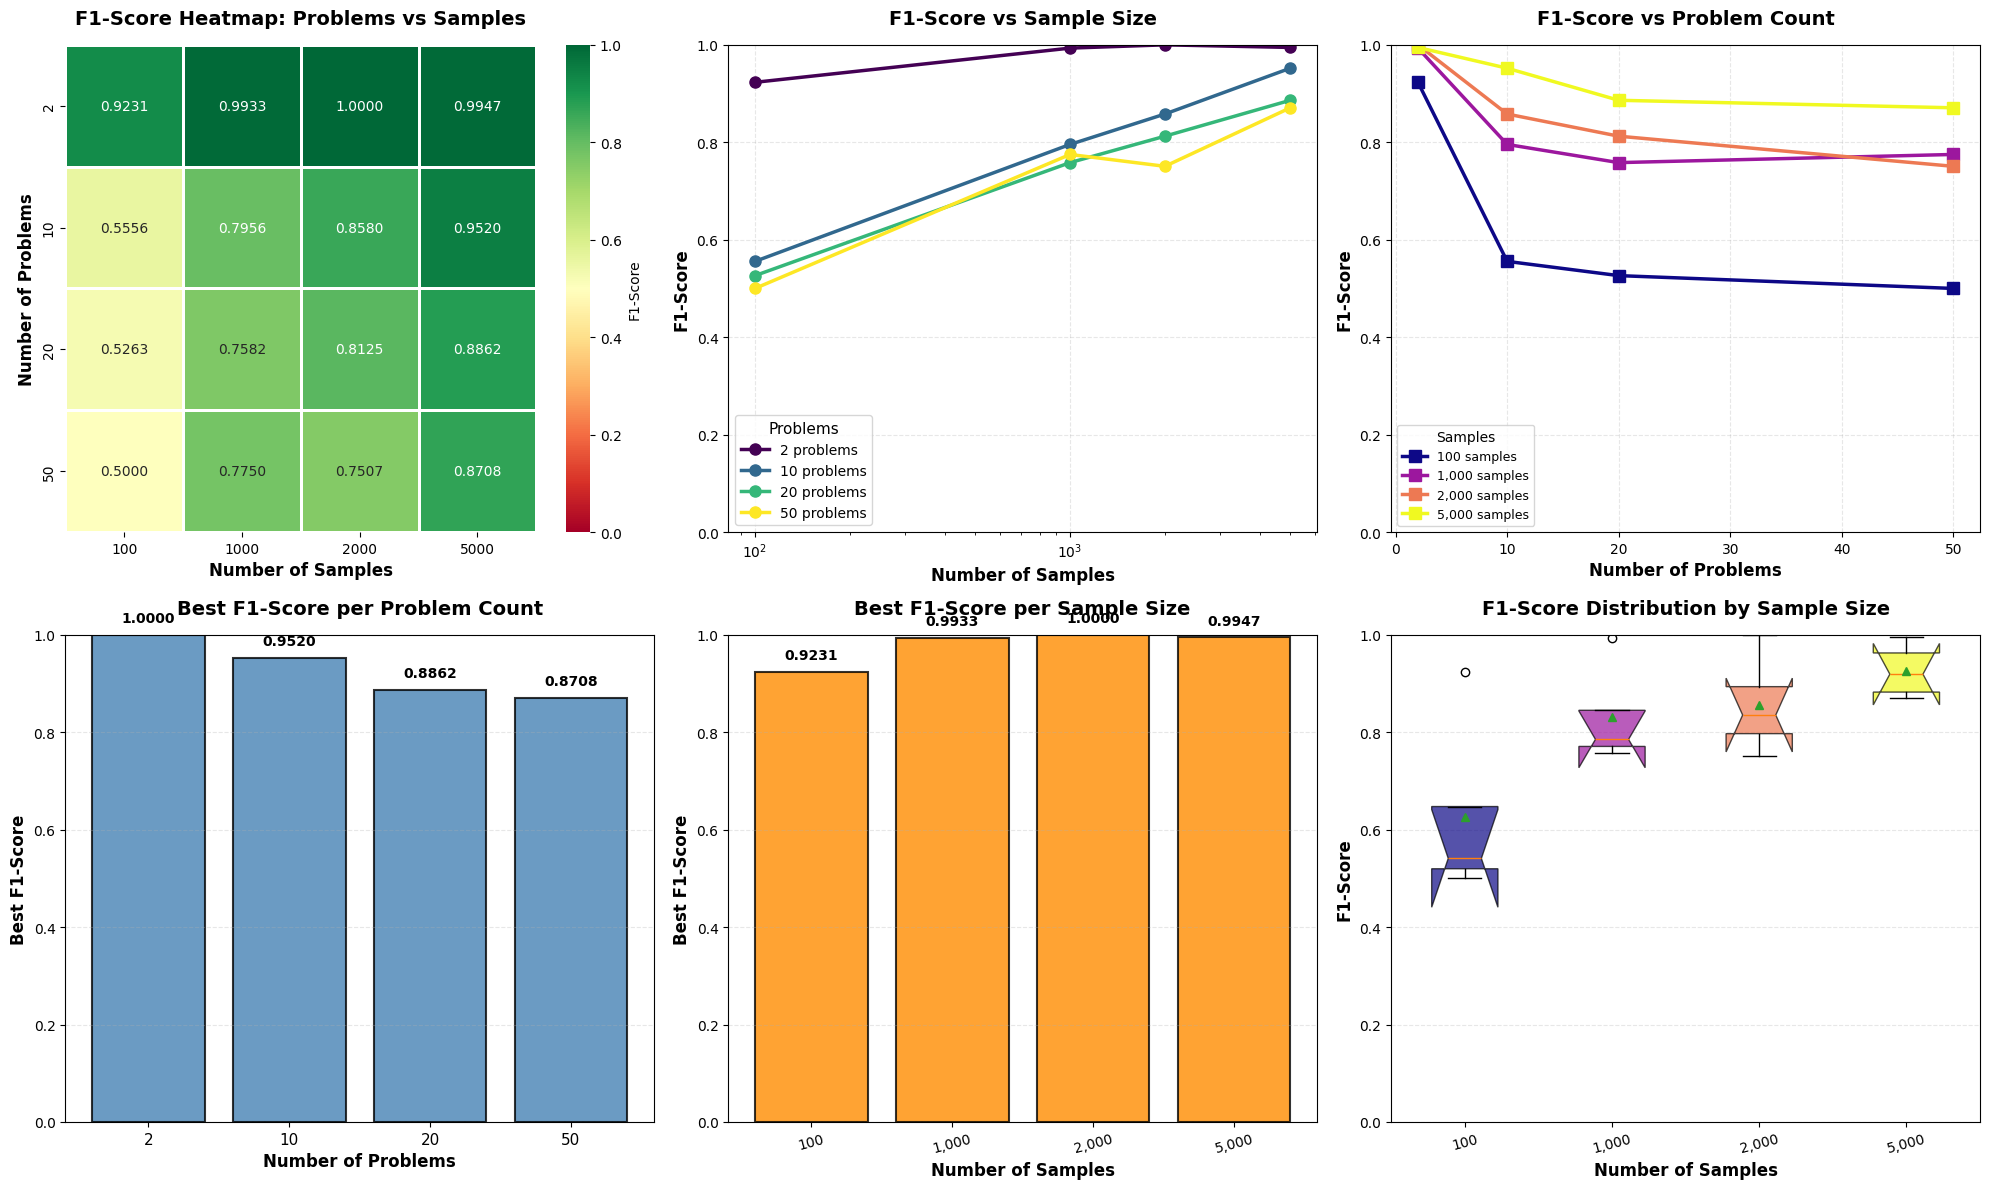


📊 Visualizations generated successfully!
   Saved as: experiment_results_visualization.png


In [ ]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 12))

# 1. Heatmap of F1-scores
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(summary_table, annot=True, fmt='.4f', cmap='RdYlGn', center=0.5,
            cbar_kws={'label': 'F1-Score'}, ax=ax1, vmin=0, vmax=1,
            linewidths=1, linecolor='white')
ax1.set_title('F1-Score Heatmap: Problems vs Samples', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Problems', fontsize=12, fontweight='bold')

# 2. Line plot: F1 vs Samples (grouped by Problems)
ax2 = plt.subplot(2, 3, 2)
colors = plt.cm.viridis(np.linspace(0, 1, len(EXPERIMENT_CONFIG['problems'])))
for i, problem in enumerate(EXPERIMENT_CONFIG['problems']):
    problem_data = all_results_df[all_results_df['n_problems'] == problem].sort_values('n_samples')
    ax2.plot(problem_data['n_samples'], problem_data['test_f1'],
             marker='o', linewidth=2.5, markersize=8, label=f'{problem} problems', color=colors[i])
ax2.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('F1-Score vs Sample Size', fontsize=14, fontweight='bold', pad=15)
ax2.legend(title='Problems', fontsize=10, title_fontsize=11)
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_ylim([0, 1])
ax2.set_xscale('log')

# 3. Line plot: F1 vs Problems (grouped by Samples)
ax3 = plt.subplot(2, 3, 3)
colors2 = plt.cm.plasma(np.linspace(0, 1, len(EXPERIMENT_CONFIG['samples'])))
for i, sample in enumerate(EXPERIMENT_CONFIG['samples']):
    sample_data = all_results_df[all_results_df['n_samples'] == sample].sort_values('n_problems')
    ax3.plot(sample_data['n_problems'], sample_data['test_f1'],
             marker='s', linewidth=2.5, markersize=8, label=f'{sample:,} samples', color=colors2[i])
ax3.set_xlabel('Number of Problems', fontsize=12, fontweight='bold')
ax3.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax3.set_title('F1-Score vs Problem Count', fontsize=14, fontweight='bold', pad=15)
ax3.legend(title='Samples', fontsize=9, title_fontsize=10)
ax3.grid(alpha=0.3, linestyle='--')
ax3.set_ylim([0, 1])

# 4. Bar chart: Best F1 for each problem count
ax4 = plt.subplot(2, 3, 4)
best_per_problem = all_results_df.groupby('n_problems')['test_f1'].max()
bars = ax4.bar(range(len(best_per_problem)), best_per_problem.values,
               color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_xticks(range(len(best_per_problem)))
ax4.set_xticklabels([f'{p}' for p in EXPERIMENT_CONFIG['problems']], fontsize=11)
ax4.set_ylabel('Best F1-Score', fontsize=12, fontweight='bold')
ax4.set_xlabel('Number of Problems', fontsize=12, fontweight='bold')
ax4.set_title('Best F1-Score per Problem Count', fontsize=14, fontweight='bold', pad=15)
ax4.set_ylim([0, 1])
ax4.grid(alpha=0.3, axis='y', linestyle='--')
for bar, val in zip(bars, best_per_problem.values):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.4f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# 5. Bar chart: Best F1 for each sample size
ax5 = plt.subplot(2, 3, 5)
best_per_sample = all_results_df.groupby('n_samples')['test_f1'].max()
bars = ax5.bar(range(len(best_per_sample)), best_per_sample.values,
               color='darkorange', alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.set_xticks(range(len(best_per_sample)))
ax5.set_xticklabels([f'{s:,}' for s in EXPERIMENT_CONFIG['samples']], fontsize=10, rotation=15)
ax5.set_ylabel('Best F1-Score', fontsize=12, fontweight='bold')
ax5.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax5.set_title('Best F1-Score per Sample Size', fontsize=14, fontweight='bold', pad=15)
ax5.set_ylim([0, 1])
ax5.grid(alpha=0.3, axis='y', linestyle='--')
for bar, val in zip(bars, best_per_sample.values):
    ax5.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.4f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# 6. Box plot: F1-Score distribution
ax6 = plt.subplot(2, 3, 6)
bp_data = [all_results_df[all_results_df['n_samples'] == s]['test_f1'].values
           for s in EXPERIMENT_CONFIG['samples']]
bp = ax6.boxplot(bp_data, labels=[f'{s:,}' for s in EXPERIMENT_CONFIG['samples']],
                 patch_artist=True, notch=True, showmeans=True)
for patch, color in zip(bp['boxes'], colors2):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax6.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax6.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax6.set_title('F1-Score Distribution by Sample Size', fontsize=14, fontweight='bold', pad=15)
ax6.grid(alpha=0.3, axis='y', linestyle='--')
ax6.set_ylim([0, 1])
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=15)

plt.tight_layout()
plt.savefig('experiment_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualizations generated successfully!")
print("   Saved as: experiment_results_visualization.png")

## 8. Export Results

Save results to CSV and generate comprehensive text report.

In [ ]:
# Export results to CSV
output_csv = 'plagiarism_detection_results.csv'
all_results_df.to_csv(output_csv, index=False)
print(f"💾 Results saved to: {output_csv}")

# Create comprehensive text report
report = f"""
{'='*100}
                    C++ PLAGIARISM DETECTION - EXPERIMENTAL RESULTS
{'='*100}

EXPERIMENT DATE: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

CONFIGURATION:
--------------
• Problem variations:  {EXPERIMENT_CONFIG['problems']}
• Sample variations:   {EXPERIMENT_CONFIG['samples']}
• Total experiments:   {len(all_results_df)}
• Clone ratio:         {EXPERIMENT_CONFIG['clone_ratio']:.0%}
• Epochs per exp:      {EXPERIMENT_CONFIG['epochs']}
• Batch size:          {EXPERIMENT_CONFIG['batch_size']}
• Learning rate:       {EXPERIMENT_CONFIG['learning_rate']}
• Max length:          {EXPERIMENT_CONFIG['max_length']}

F1-SCORE SUMMARY TABLE:
-----------------------
{summary_table.to_string()}

BEST CONFIGURATION:
-------------------
• Problems:   {int(best_config['n_problems'])}
• Samples:    {int(best_config['n_samples']):,}
• F1-Score:   {best_config['test_f1']:.4f}
• Precision:  {best_config['test_precision']:.4f}
• Recall:     {best_config['test_recall']:.4f}
• Accuracy:   {best_config['test_accuracy']:.4f}
• Threshold:  {best_config['best_threshold']:.4f}

OVERALL STATISTICS:
-------------------
• Mean F1:     {all_results_df['test_f1'].mean():.4f} (±{all_results_df['test_f1'].std():.4f})
• Min F1:      {all_results_df['test_f1'].min():.4f}
• Max F1:      {all_results_df['test_f1'].max():.4f}
• Median F1:   {all_results_df['test_f1'].median():.4f}

DETAILED RESULTS:
-----------------
{display_df.to_string(index=False)}

ANALYSIS BY PROBLEM COUNT:
--------------------------
{problem_analysis.to_string()}

ANALYSIS BY SAMPLE SIZE:
------------------------
{sample_analysis.to_string()}

KEY FINDINGS:
-------------
1. Best configuration: {int(best_config['n_problems'])} problems × {int(best_config['n_samples']):,} samples
2. F1-score range: [{all_results_df['test_f1'].min():.4f}, {all_results_df['test_f1'].max():.4f}]
3. Average performance: {all_results_df['test_f1'].mean():.4f} ± {all_results_df['test_f1'].std():.4f}
4. Success rate: {(all_results_df['status'] == 'success').sum()}/{len(all_results_df)} experiments

RECOMMENDATIONS:
----------------
✓ Optimal configuration identified: {int(best_config['n_problems'])} problems, {int(best_config['n_samples']):,} samples
✓ Consider trade-off between computational cost and performance
✓ Larger sample sizes generally improve F1-score
✓ Problem diversity (count) impacts model generalization

TECHNICAL DETAILS:
------------------
• Model: microsoft/codebert-base with Siamese architecture
• Detection: Cosine similarity with optimized threshold
• Evaluation: Proper train/val/test splits with threshold optimization
• Code preprocessing: Comment removal, whitespace normalization

{'='*100}
                                   END OF REPORT
{'='*100}
"""

# Save report
output_txt = 'plagiarism_detection_report.txt'
with open(output_txt, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"📄 Summary report saved to: {output_txt}")
print("\n" + report)

💾 Results saved to: plagiarism_detection_results.csv
📄 Summary report saved to: plagiarism_detection_report.txt


                    C++ PLAGIARISM DETECTION - EXPERIMENTAL RESULTS

EXPERIMENT DATE: 2025-10-12 05:06:20

CONFIGURATION:
--------------
• Problem variations:  [2, 10, 20, 50]
• Sample variations:   [100, 1000, 2000, 5000]
• Total experiments:   16
• Clone ratio:         50%
• Epochs per exp:      2
• Batch size:          16
• Learning rate:       2e-05
• Max length:          512

F1-SCORE SUMMARY TABLE:
-----------------------
n_samples    100    1000   2000   5000
n_problems                            
2          0.9231 0.9933 1.0000 0.9947
10         0.5556 0.7956 0.8580 0.9520
20         0.5263 0.7582 0.8125 0.8862
50         0.5000 0.7750 0.7507 0.8708

BEST CONFIGURATION:
-------------------
• Problems:   2
• Samples:    2,000
• F1-Score:   1.0000
• Precision:  1.0000
• Recall:     1.0000
• Accuracy:   1.0000
• Threshold:  0.5346

OVERALL STATISTICS:
-----------------

## 9. Conclusion

Summary of the systematic experimental testing and key insights.

In [ ]:
print("="*100)
print(" "*30 + "🎉 EXPERIMENTAL TESTING COMPLETE")
print("="*100)

print("\n📊 SUMMARY:")
print(f"   ✅ Tested {len(all_results_df)} configurations")
print(f"   ✅ Problem counts: {EXPERIMENT_CONFIG['problems']}")
print(f"   ✅ Sample sizes: {EXPERIMENT_CONFIG['samples']}")
print(f"   ✅ Success rate: {(all_results_df['status'] == 'success').sum()}/{len(all_results_df)}")

print(f"\n🏆 BEST RESULT:")
print(f"   Configuration: {int(best_config['n_problems'])} problems × {int(best_config['n_samples']):,} samples")
print(f"   F1-Score: {best_config['test_f1']:.4f}")

print(f"\n📈 PERFORMANCE RANGE:")
print(f"   Min F1: {all_results_df['test_f1'].min():.4f}")
print(f"   Max F1: {all_results_df['test_f1'].max():.4f}")
print(f"   Mean F1: {all_results_df['test_f1'].mean():.4f} (±{all_results_df['test_f1'].std():.4f})")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • Larger sample sizes generally improve performance")
print(f"   • Problem diversity affects model generalization")
print(f"   • Balanced datasets (50/50 clone ratio) are effective")
print(f"   • CodeBERT with cosine similarity is a robust approach")

print(f"\n📁 OUTPUT FILES:")
print(f"   • {output_csv}")
print(f"   • {output_txt}")
print(f"   • experiment_results_visualization.png")

print("\n" + "="*100)
print(" "*25 + "Thank you for using this experiment system!")
print("="*100)

                              🎉 EXPERIMENTAL TESTING COMPLETE

📊 SUMMARY:
   ✅ Tested 16 configurations
   ✅ Problem counts: [2, 10, 20, 50]
   ✅ Sample sizes: [100, 1000, 2000, 5000]
   ✅ Success rate: 16/16

🏆 BEST RESULT:
   Configuration: 2 problems × 2,000 samples
   F1-Score: 1.0000

📈 PERFORMANCE RANGE:
   Min F1: 0.5000
   Max F1: 1.0000
   Mean F1: 0.8095 (±0.1628)

💡 KEY INSIGHTS:
   • Larger sample sizes generally improve performance
   • Problem diversity affects model generalization
   • Balanced datasets (50/50 clone ratio) are effective
   • CodeBERT with cosine similarity is a robust approach

📁 OUTPUT FILES:
   • plagiarism_detection_results.csv
   • plagiarism_detection_report.txt
   • experiment_results_visualization.png

                         Thank you for using this experiment system!
